In [224]:
import json
import operator
from argparse import ArgumentParser
from collections import defaultdict
from functools import reduce
from pathlib import Path
from typing import List, Iterable, Any, Dict
import pandas as pd

from veniq.ast_framework import AST, ASTNodeType, ASTNode
from javalang.parse import parse
from javalang.parser import JavaSyntaxError
from veniq.metrics.ncss.ncss import NCSSMetric
from program_slicing.decomposition.block_slicing import build_opportunities
from program_slicing.decomposition.program_slice import ProgramSlice
from program_slicing.decomposition.block_slicing import build_opportunities_filtered
from program_slicing.decomposition.program_slice import ProgramSlice
from program_slicing.decomposition.program_slice import ProgramSlice
from program_slicing.decomposition.slice_predicate import SlicePredicate
from program_slicing.graph.manager import ProgramGraphsManager
from program_slicing.graph.statement import Statement, StatementType
from program_slicing.graph.point import Point
from sortedcontainers import SortedDict
from program_slicing.graph.parse import LANG_JAVA
from sortedcontainers import SortedDict
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from collections import Counter
from numpy import mean, var

IGNORE_USERS = {"zorchenkov.alexey@huawei.com", "zhyryk2021@rambler.ru", "cylyavaivai@gmail.com", "chizhyk2pyzhik@mail.ru"}
java_dir = Path(r'D:\git\program_slicing2\program_slicing\decomposition\files_iter2\java_files')
json_path = Path(r'D:\git\program_slicing2\program_slicing\decomposition\files_iter2\current_batch.json')

In [6]:
def get_web_configs():
    d = Path(r'D:\\git\\program_slicing2\\program_slicing\\decomposition\\files_iter2')
    small_config_filepath = d / 'web_config/small_config.json'
    large_config_filepath = d / 'web_config/large_config.json'
    with open(small_config_filepath) as f:
        small_config = json.loads(f.read())
    with open(large_config_filepath) as f:
        large_config = json.loads(f.read())

    return small_config, large_config

In [7]:
def get_all_methods_config(
        config: Dict[str, Any],
        max_answers_percentage=0.8):

    methods_dict = defaultdict(list)
   
    for x in all_configs:
        methods_dict[x['method_id']].append(x)
    return methods_dict
small_config, large_config = get_web_configs()
all_configs = large_config + small_config
all_methods_config = get_all_methods_config(all_configs)

In [8]:
def get_all_answers_dict(json_path):
    answers_by_users = {}
    with open(json_path) as f:
        answers = json.loads(f.read())
        
        for x in answers.get('data').get('listAnswers').get('items'):
            if x['user'] not in IGNORE_USERS:
                user_dict = answers_by_users.get(x['user'])
                if user_dict:
                    answers_by_method_id = user_dict.get(x['method'])
                    if answers_by_method_id:
                        sample_id = answers_by_method_id.get(x['question'])
                        if sample_id:
                            sample_id.append(x)
                        else:
                            answers_by_method_id[x['question']] = [x]
                    else:
                        user_dict[x['method']] = {x['question']: [x]}
                else:
                    answers_by_users[x['user']] = {x['method']: {x['question']: [x]}}
                
    return answers_by_users
all_answers_dict = get_all_answers_dict(json_path)

In [9]:
def filter_answers(all_answers_dict, all_methods_config, max_diff_ids=3):
    
    filtered_answers = defaultdict(list)
    for user, methods_dict in all_answers_dict.items():
#         print(user)
        for method_id, questions_dict in methods_dict.items():
            print(user, method_id)
            config_answers = {x['sample_id'] for x in all_methods_config[method_id]}
#             print(config_answers)
            user_answers = set(questions_dict.keys())
            diff = config_answers.difference(user_answers)
            if len(diff) <= max_diff_ids:
                filtered_answers[method_id].extend(questions_dict.values())
               
    new_filtered_answers = {}
    for method_id, vals in filtered_answers.items():
        new_vals = reduce(operator.concat, vals)
        new_filtered_answers[method_id] = new_vals
    return new_filtered_answers

filtered_answers = filter_answers(all_answers_dict, all_methods_config)
filtered_answers

websprogrammer@gmail.com method_16.java
websprogrammer@gmail.com method_14.java
websprogrammer@gmail.com method_12.java
websprogrammer@gmail.com method_19.java
websprogrammer@gmail.com method_18.java
websprogrammer@gmail.com method_8.java
websprogrammer@gmail.com method_10.java
websprogrammer@gmail.com method_15.java
websprogrammer@gmail.com method_17.java
websprogrammer@gmail.com method_13.java
websprogrammer@gmail.com method_11.java
andrei.tatarnikov@huawei.com method_8.java
andrei.tatarnikov@huawei.com method_3.java
andrei.tatarnikov@huawei.com method_5.java
andrei.tatarnikov@huawei.com method_1.java
andrei.tatarnikov@huawei.com method_0.java
andrei.tatarnikov@huawei.com method_9.java
andrei.tatarnikov@huawei.com method_4.java
andrei.tatarnikov@huawei.com method_6.java
andrei.tatarnikov@huawei.com method_7.java
andrei.tatarnikov@huawei.com method_2.java
wanghaitao6@huawei.com method_12.java
wanghaitao6@huawei.com method_11.java
wanghaitao6@huawei.com method_19.java
wanghaitao6@huawe

{'method_16.java': [{'id': 'f41f8ec3-270f-41bd-8545-b3b859032aaa',
   'question': 163,
   'answer': 'yes',
   'user': 'websprogrammer@gmail.com',
   'method': 'method_16.java',
   'createdAt': '2021-06-23T10:41:45.467Z',
   'updatedAt': '2021-06-23T10:41:45.467Z'},
  {'id': '6ae29e6e-7da1-46a2-aee2-3e33e44009c2',
   'question': 160,
   'answer': 'no',
   'user': 'websprogrammer@gmail.com',
   'method': 'method_16.java',
   'createdAt': '2021-06-23T09:51:08.010Z',
   'updatedAt': '2021-06-23T09:51:08.010Z'},
  {'id': '6f49ea04-8e4f-4a04-890a-420717dd37d5',
   'question': 161,
   'answer': 'yes',
   'user': 'websprogrammer@gmail.com',
   'method': 'method_16.java',
   'createdAt': '2021-06-23T10:34:06.210Z',
   'updatedAt': '2021-06-23T10:34:06.210Z'},
  {'id': '7a7d8385-8368-4c9d-a388-9f9ada5b5524',
   'question': 164,
   'answer': 'no',
   'user': 'websprogrammer@gmail.com',
   'method': 'method_16.java',
   'createdAt': '2021-06-23T10:21:48.887Z',
   'updatedAt': '2021-06-23T10:21:48.

In [6]:
#all_methods_config

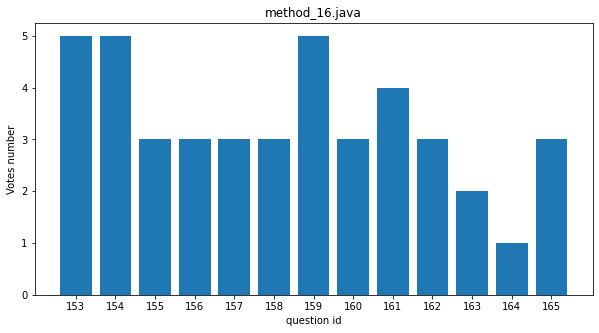

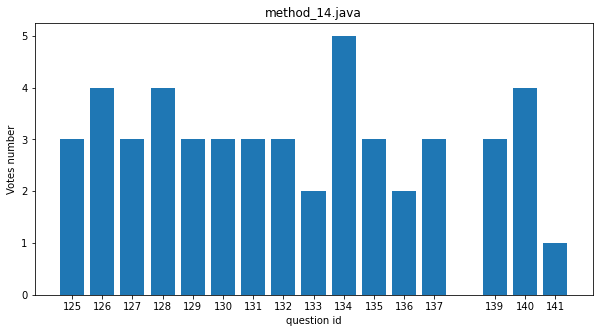

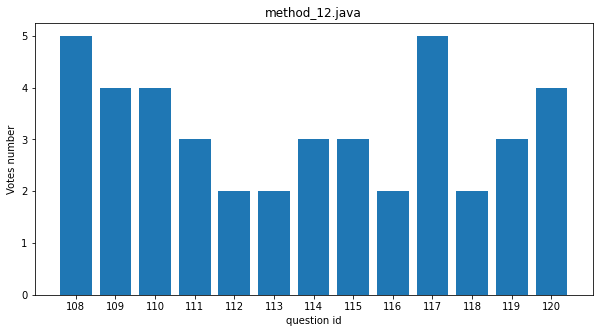

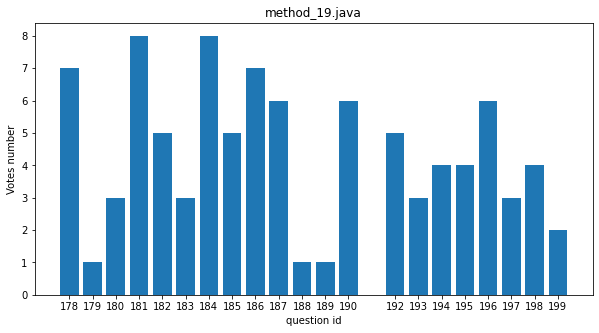

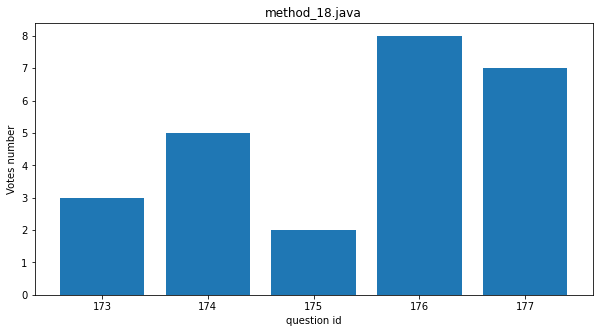

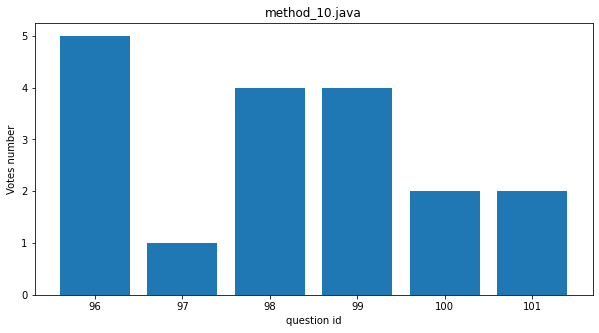

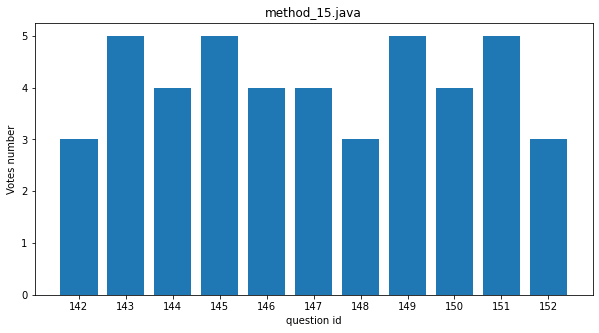

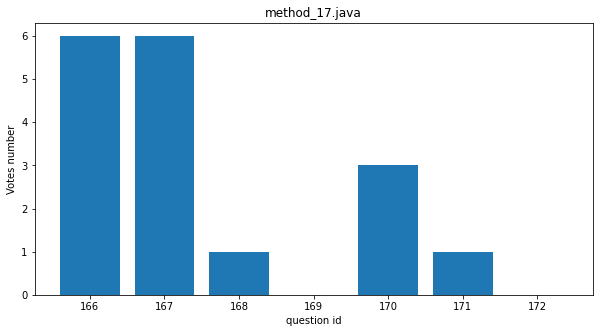

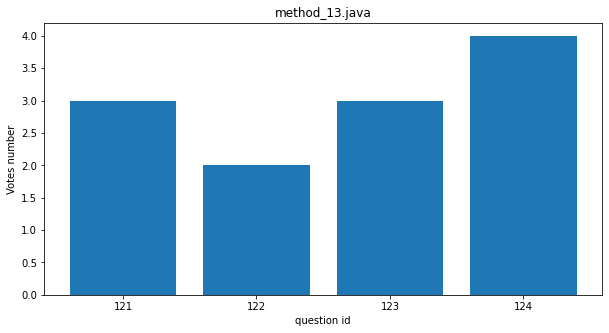

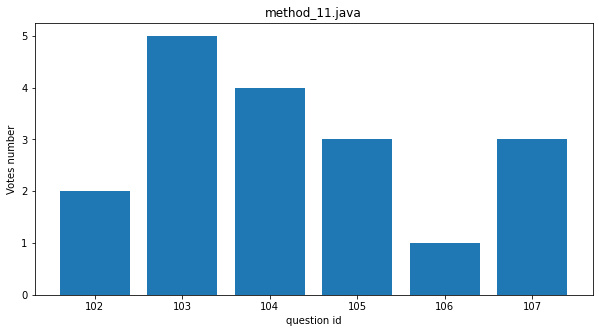

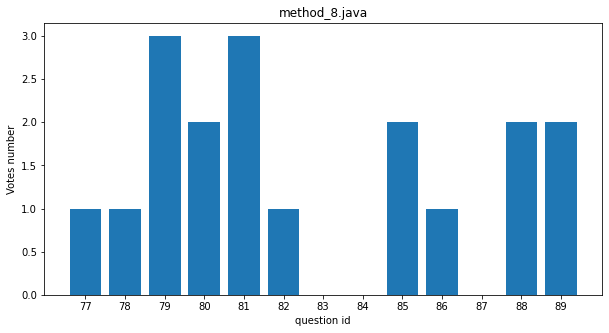

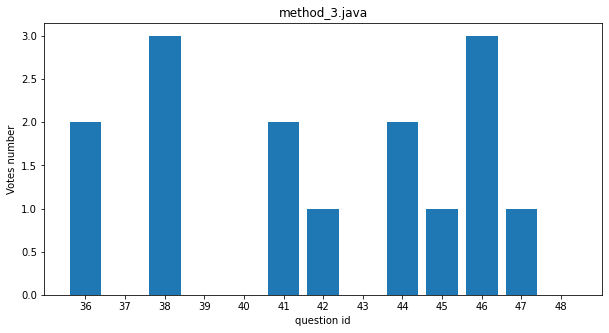

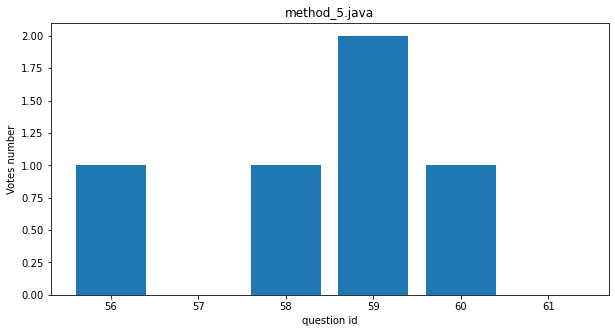

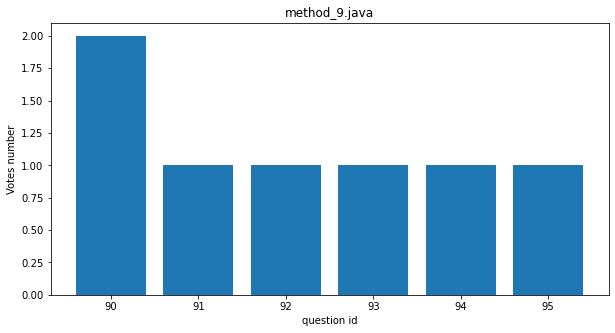

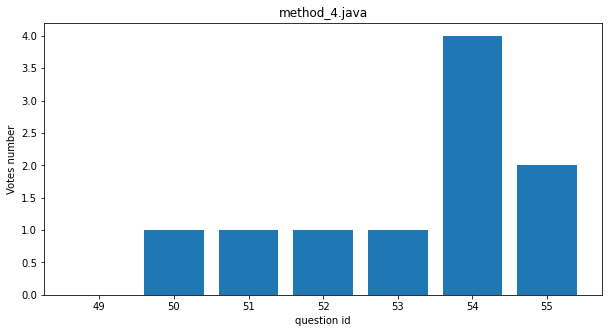

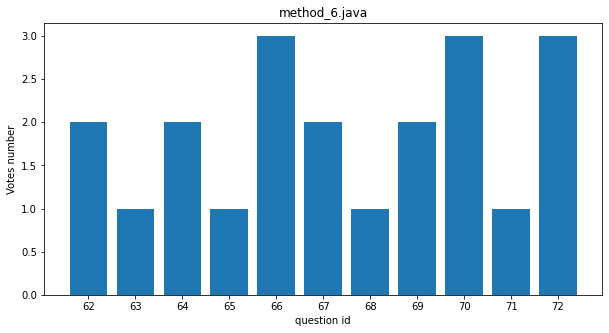

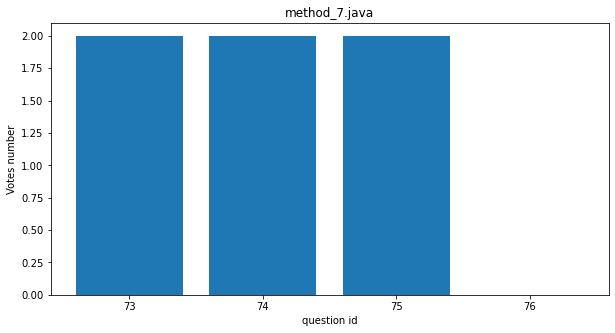

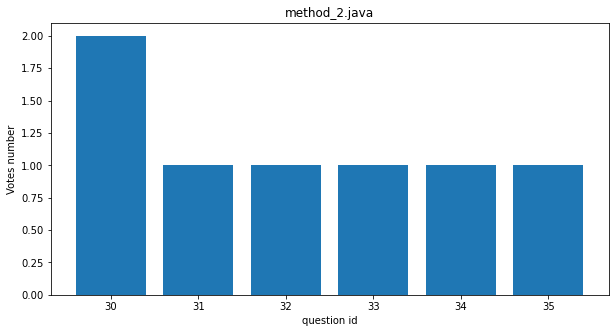

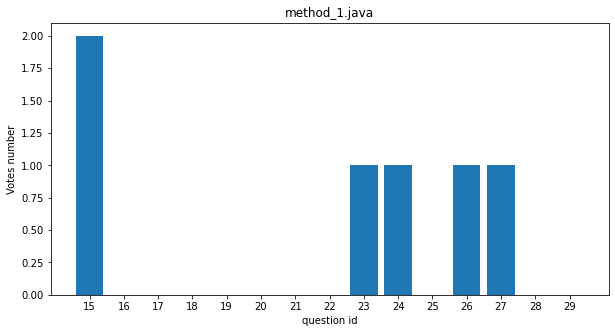

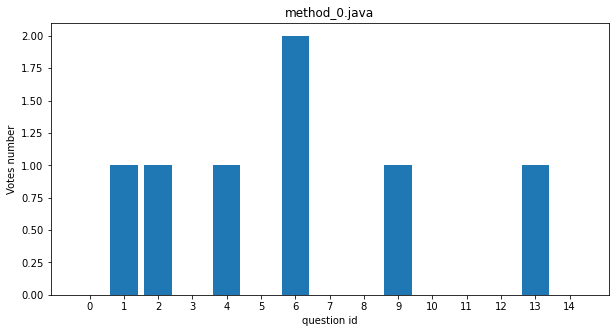

In [10]:
def show_bars(vals, method_id):
    plt.rcParams["figure.figsize"] = (10,5)
    plt.bar([int(x) for x in vals.keys()], [int(x) for x in vals.values()])
    plt.title(method_id)
    plt.xticks([int(x) for x in vals.keys()])
    plt.xlabel('question id')
    plt.ylabel('Votes number')
    plt.show()
    


def find_not_answered_questions(filtered_answers):
    ans_yes = defaultdict(list)
#     ans_no = defaultdict(list)
    for method_id, answers in filtered_answers.items():
        for x in answers:
            if x['answer'] == "yes":
                ans_yes[method_id].append(x['question'])
    #         else:
    #             ans_no[method_id].append(['question']})

    all_vals = {}
    for method_id, answers in ans_yes.items():
    #     ans = reduce(operator.concat, [list(x.values()) for x in answers])
        answered = set(ans_yes[method_id])
        config_items = {x['sample_id'] for x in all_methods_config.get(method_id)}
    #     print(method_id, config_items)
        # find which answers were no or were not answered at all  
        missed = config_items.difference(answered)
        missed_dict = {}
        if missed:
            missed_dict = {x: 0 for x in missed}
    #         print('Missed ', method_id, missed_dict)
        vals = {**Counter(answers), **missed_dict}
        not_answered_by_users = {x for x, y in vals.items() if y == 0}
        if not_answered_by_users:
            all_vals[method_id] = not_answered_by_users
    #     print(method_id, vals)
        show_bars(vals, method_id)
    
    return all_vals

not_answered = find_not_answered_questions(filtered_answers)

In [11]:
print('not_answered: ', not_answered)

def print_debug_code(start, end, code):
    print('####################################################')
    print(start, end)
    print(code)
    print('####################################################3')

def get_non_filtered_slices(all_methods_config, not_answered):
    slices = defaultdict(list)
    for method_id, d in all_methods_config.items():
    #     method_id = 'method_0.java'
        not_answered_q = not_answered.get(method_id)
        if not_answered_q:
            with open(java_dir / method_id) as f:
                code = f.read()
            htmls = [x['html'] for x in d if x['sample_id'] in not_answered_q]
#             print(method_id)
            not_answered_lines = set()
            for html in htmls:
                string_parsed = html.split(Path(method_id).stem)[1].split('.')[0].split('_')[1:3]
                start = int(string_parsed[0])
                end = int(string_parsed[1])
                not_answered_lines.add((start, end))
    #             code = '\n'.join(code_lines[start - 1:end])
    #             print_debug_code(code)
#             print(not_answered_lines)
            found_opportunities = {
                program_slice
                for program_slice in build_opportunities_filtered(
                  code, LANG_JAVA, min_amount_of_lines=6, max_percentage_of_lines=0.8) 
                if (program_slice.ranges[0][0].line_number + 1, program_slice.ranges[-1][1].line_number + 1) in not_answered_lines
            }
#             opporunitites_currently_not_ignored = not_answered_lines.intersection(found_opportunities)
            if found_opportunities:
                slices[method_id].extend(found_opportunities)
            
    for method_id, slc in slices.items():
        set_lines = {(x.ranges[0][0].line_number + 1, x.ranges[-1][1].line_number + 1) for x in slc}
        print(f'EMOs are not ignored: {method_id} {set_lines}')
        
    return slices
    #         print(f'EMOs to ignore: {not_answered_lines}')

non_filtered_slices = get_non_filtered_slices(all_methods_config, not_answered)      

not_answered:  {'method_17.java': {169, 172}, 'method_8.java': {83, 84, 87}, 'method_3.java': {37, 39, 40, 43, 48}, 'method_5.java': {57, 61}, 'method_4.java': {49}, 'method_7.java': {76}, 'method_1.java': {16, 17, 18, 19, 20, 21, 22, 25, 28, 29}, 'method_0.java': {0, 3, 5, 7, 8, 10, 11, 12, 14}}
EMOs are not ignored: method_17.java {(56, 67), (49, 62)}
EMOs are not ignored: method_0.java {(23, 42), (24, 36), (24, 35), (26, 32), (3, 9), (21, 40), (23, 40), (24, 34), (19, 40)}
EMOs are not ignored: method_1.java {(20, 30), (7, 16), (9, 15), (5, 16), (20, 28)}
EMOs are not ignored: method_3.java {(8, 32), (11, 32), (25, 32), (12, 26)}
EMOs are not ignored: method_4.java {(4, 22)}
EMOs are not ignored: method_5.java {(11, 17)}
EMOs are not ignored: method_7.java {(23, 29)}
EMOs are not ignored: method_8.java {(43, 55), (21, 55), (20, 55)}


In [12]:
all_methods_config

defaultdict(list,
            {'method_10.java': [{'sample_id': 96,
               'method_id': 'method_10.java',
               'html': 'examples/method_10_22_37.html',
               'has_true_emo': False,
               'group': 'large'},
              {'sample_id': 97,
               'method_id': 'method_10.java',
               'html': 'examples/method_10_23_32.html',
               'has_true_emo': False,
               'group': 'large'},
              {'sample_id': 98,
               'method_id': 'method_10.java',
               'html': 'examples/method_10_23_36.html',
               'has_true_emo': False,
               'group': 'large'},
              {'sample_id': 99,
               'method_id': 'method_10.java',
               'html': 'examples/method_10_24_32.html',
               'has_true_emo': False,
               'group': 'large'},
              {'sample_id': 100,
               'method_id': 'method_10.java',
               'html': 'examples/method_10_24_36.html',
     

In [15]:
def count_main_statements(block_slice: ProgramSlice):
    start_line = block_slice.ranges[0][0].line_number
    end_line = block_slice.ranges[-1][1].line_number
    code = str(block_slice)
#     print(code)
    manager = ProgramGraphsManager(code, LANG_JAVA)
    ddg = manager.get_data_dependence_graph()
    statements_for_slice = [(x.ast_node_type, x.start_point.line_number + 1, x.end_point.line_number + 1) 
        for x in ddg if x.ast_node_type in ['expression_statement', 'variable_declarator']
    ]
#     print(statements_for_slice)
    return len(statements_for_slice)

In [17]:
def count_main_statements_by_comma_delimiter(block_slice: ProgramSlice, method_id):
    start_line = block_slice.ranges[0][0].line_number
    end_line = block_slice.ranges[-1][1].line_number
#     print(method_id, start_line + 1, end_line + 1)
#     code = reduce(operator.add, [x.count(';') for x in str(block_slice).splitlines() if x.count(';') > 0])
    code = [(x.count(';'), x) for x in str(block_slice).splitlines() if x.count(';') > 0]
#     print(block_slice)
    return len(code)
#     return code

In [506]:
def is_var_decl_last_statement(block_slice: ProgramSlice):
    start_line = block_slice.ranges[0][0].line_number
    end_line = block_slice.ranges[-1][1].line_number
#     print(block_slice)
    code = str(block_slice)
    manager = ProgramGraphsManager(code, LANG_JAVA)
    ddg = manager.get_data_dependence_graph()
    var_decls_lines = [list(range(x.start_point.line_number + 1, x.end_point.line_number + 2) )
        for x in ddg if x.ast_node_type in ['variable_declarator']
    ]
    if var_decls_lines:
        var_decls_lines = set(reduce(operator.concat, var_decls_lines))
        total_lines_number = len(code.split('\n'))
#         print(total_lines_number, var_decls_lines)
        if total_lines_number in var_decls_lines:
            
#             print('##############################')
            return True
        else:
#             print('##############################')
            return False
    else:
#         print('##############################')
        return False

# def is_var_decl_first_statement(block_slice: ProgramSlice, source_code, ddg_all):
#     lines = source_code.split('\n')
#     start_line = block_slice.ranges[0][0].line_number
#     end_line = block_slice.ranges[-1][1].line_number
#     print('##############################')
#     print(start_line, end_line, block_slice)
#     code = str(block_slice)
        
#     manager = ProgramGraphsManager(code, LANG_JAVA)
#     ddg = manager.get_data_dependence_graph()
#     var_decls_lines = [list(range(x.start_point.line_number + 1, x.end_point.line_number + 2) )
#         for x in ddg if x.ast_node_type in ['variable_declarator']
#     ]
#     all_statements = [list(range(x.start_point.line_number + 1, x.end_point.line_number + 2) )
#         for x in ddg_all
#     ]
#     if var_decls_lines:
#         var_decls_lines = sorted(reduce(operator.concat, var_decls_lines))
#         all_statements = sorted(set(reduce(operator.concat, all_statements)))
# #         print(all_statements)
#         before_statements = [x for x in all_statements if x < start_line]
#         print(before_statements)
#         before_statements = [lines[x] for x in all_statements if x < start_line]
# #         print(before_statements)
#         total_lines_number = len(code.split('\n'))
# #         print(total_lines_number, var_decls_lines)
#         if 1 in var_decls_lines:
# #             print('##############################')
#             return True
#         else:
# #             print('##############################')
#             return False
#     else:
# #         print('##############################')
#         return False

In [58]:
def parse_config_slices(config):
    slices = defaultdict(list)
#     samples = []
    for method_id, answers in config.items():
        filepath = java_dir / method_id
        #             print(method_id)
        with open(filepath) as f:
            source_code = f.read()
            source_lines = source_code.split('\n')
            manager = ProgramGraphsManager(source_code, LANG_JAVA)
            ddg = manager.get_data_dependence_graph() 
            
            for ans in answers:
                html = ans['html']
                string_parsed = html.split(Path(method_id).stem)[1].split('.')[0].split('_')[1:3]
                start = int(string_parsed[0]) - 1
                end = int(string_parsed[1]) - 1

                stats = [x for x in ddg if (x.start_point.line_number >= start) and (x.end_point.line_number <= end)]
                slice_t = ProgramSlice(source_lines).from_statements(stats)
#                 print(dir(slice_t))
#                 print(method_id, start + 1, end + 1)
#                 print('#######################')
#                 print(slice_t)
#                 print('#######################')
                slices[method_id].append((slice_t, ans['sample_id']))
#                 samples.append(ans['sample_id'])
        #         print(answers)
    return slices

slices = parse_config_slices(all_methods_config)
slices
# print(all_slices_for_config)

defaultdict(list,
            {'method_10.java': [(ProgramSlice(ranges=None, source_lines=['void checkMethods() {', '\tboolean mustImplementAbstractMethods = mustImplementAbstractMethods();', '\tboolean skipInheritedMethods = mustImplementAbstractMethods && canSkipInheritedMethods(); // have a single concrete superclass so only check overridden methods', '\tchar[][] methodSelectors = this.inheritedMethods.keyTable;', '\tnextSelector : for (int s = methodSelectors.length; --s >= 0;) {', '\t\tif (methodSelectors[s] == null) continue nextSelector;', '', '\t\tMethodBinding[] current = (MethodBinding[]) this.currentMethods.get(methodSelectors[s]);', '\t\tif (current == null && skipInheritedMethods)', '\t\t\tcontinue nextSelector;', '', '\t\tMethodBinding[] inherited = (MethodBinding[]) this.inheritedMethods.valueTable[s];', '\t\tif (inherited.length == 1 && current == null) { // handle the common case', '\t\t\tif (mustImplementAbstractMethods && inherited[0].isAbstract())', '\t\t\t\tcheckAb

In [511]:

def count_lines_and_statements(slices, java_dir, not_answered):
    results = []
    
    for method_id, list_of_slices in slices.items():
    #         print(method_id)
        with open(java_dir / method_id) as f:
            source_code = f.read()
        manager = ProgramGraphsManager(source_code, LANG_JAVA)
        ddg_all = manager.get_data_dependence_graph()
#             source_lines = source_code.split("\n")
#             full_manager = ProgramGraphsManager(source_code, LANG_JAVA)
#             full_ddg = full_manager.get_data_dependence_graph()
#             a = []
#             for x in full_ddg:
#                 a.append((x.start_point.line_number + 1, x.ast_node_type))
            #print(sorted(a, key=lambda x: x[0]))
        for item in list_of_slices:
            block_slice = item[0]
            sample_id = item[1]
            start_line = block_slice.ranges[0][0].line_number
            end_line = block_slice.ranges[-1][1].line_number
            code_for_block = str(block_slice)
            fake_function = f'''class Foo {{\n public void function() {{ \n\t{str(code_for_block)}\n }}\n}}'''
    #                 print(fake_function)
            try:
                ast = AST.build_from_javalang(parse(fake_function))
                m_decl = [node for node in ast.get_proxy_nodes(ASTNodeType.METHOD_DECLARATION)][0]
    #                     print(m_decl.name)
                ncss = NCSSMetric().value(ast.get_subtree(m_decl))
                vars_total = {node.member for node in ast.get_subtree(m_decl).get_proxy_nodes(ASTNodeType.MEMBER_REFERENCE)}
                var_usage = len(vars_total)
            except Exception as e:
                print(e)
                cc = -1
                ncss = -1
                var_usage = -1
    #                 statements_for_slice = count_main_statements(block_slice)
            statements_for_slice = count_main_statements_by_comma_delimiter(block_slice, method_id)
            is_last_var_d = is_var_decl_last_statement(block_slice)
#             is_first_var_d = is_var_decl_first_statement(block_slice, source_code, ddg_all)
    #             print(dir(block_slice))
    #             print(method_id, sample_id, )
            answers_witout_votes_by_method_id = not_answered.get(method_id)
            if answers_witout_votes_by_method_id:
                if sample_id in answers_witout_votes_by_method_id:
                    were_missed = 0
                else:
                    were_missed = 1
            else:
                were_missed = 1

            lines_number = end_line - start_line
            lines_non_space_symb = [len(x.strip()) for x in code_for_block.split('\n')]
            row = {
                'method_id': method_id, 'start_line': start_line + 1, 
                'end_line': end_line + 1, 'main_st_number': statements_for_slice, 
                'ncss': ncss, 'var_usage': var_usage, 'sample_id': sample_id, 
                'were_missed': were_missed , 'is_last_var_declaration': is_last_var_d,
                'lines': lines_number, 'diff_lines_var_usage': lines_number - var_usage, 
                'non_spaces_symb_avg': mean(lines_non_space_symb), 
                'non_spaces_symb_variance': var(lines_non_space_symb),
                'diff_lines_main_st': lines_number - statements_for_slice,
                'div_lines_var_usage': lines_number / var_usage, 
                'div_lines_main_st': lines_number / statements_for_slice}

            results.append(row)
    #                     print(statements_for_slice)
    return results
                

# print(non_filtered_slices)
dict_with_main_st = count_lines_and_statements(slices, java_dir, not_answered)
dict_with_main_st

[{'method_id': 'method_10.java',
  'start_line': 22,
  'end_line': 37,
  'main_st_number': 8,
  'ncss': 13,
  'var_usage': 11,
  'sample_id': 96,
  'were_missed': 1,
  'is_last_var_declaration': False,
  'lines': 15,
  'diff_lines_var_usage': 4,
  'non_spaces_symb_avg': 35.125,
  'non_spaces_symb_variance': 859.859375,
  'diff_lines_main_st': 7,
  'div_lines_var_usage': 1.3636363636363635,
  'div_lines_main_st': 1.875},
 {'method_id': 'method_10.java',
  'start_line': 23,
  'end_line': 32,
  'main_st_number': 5,
  'ncss': 8,
  'var_usage': 10,
  'sample_id': 97,
  'were_missed': 1,
  'is_last_var_declaration': False,
  'lines': 9,
  'diff_lines_var_usage': -1,
  'non_spaces_symb_avg': 34.4,
  'non_spaces_symb_variance': 761.8399999999999,
  'diff_lines_main_st': 4,
  'div_lines_var_usage': 0.9,
  'div_lines_main_st': 1.8},
 {'method_id': 'method_10.java',
  'start_line': 23,
  'end_line': 36,
  'main_st_number': 7,
  'ncss': 12,
  'var_usage': 10,
  'sample_id': 98,
  'were_missed': 1,

In [512]:
pd.set_option('display.max_rows', 500)
df = pd.DataFrame(columns=[
    'method_id', 'start_line', 'end_line', 'main_st_number', 'ncss', 'var_usage',
     'were_missed', 'is_last_var_declaration', 'lines', 'diff_lines_var_usage', 'diff_lines_main_st',
     'div_lines_var_usage','div_lines_main_st', 'non_spaces_symb_avg', 'non_spaces_symb_variance',
])
for x in dict_with_main_st:
    df = df.append(x, ignore_index=True)
df = df.set_index('sample_id')
df = df.sort_values(by=['were_missed', 'main_st_number'], ascending=[True, False])
df.to_csv('train.csv')
df

,method_id,start_line,end_line,main_st_number,ncss,var_usage,were_missed,is_last_var_declaration,lines,diff_lines_var_usage,diff_lines_main_st,div_lines_var_usage,div_lines_main_st,non_spaces_symb_avg,non_spaces_symb_variance
sample_id,,,,,,,,,,,,,,,
3.0,method_0.java,19,40,11,17,7,0,False,21,14,10,3.000000,1.909091,23.250000,287.787500
83.0,method_8.java,20,55,11,22,7,0,False,35,28,24,5.000000,3.181818,28.142857,701.836735
5.0,method_0.java,21,40,10,16,7,0,False,19,12,9,2.714286,1.900000,22.789474,298.692521
8.0,method_0.java,23,42,10,16,8,0,False,19,11,9,2.375000,1.900000,21.473684,252.986150
37.0,method_3.java,8,32,10,17,3,0,False,24,21,14,8.000000,2.400000,37.105263,1035.673130
84.0,method_8.java,21,55,10,21,7,0,False,34,27,24,4.857143,3.400000,28.481481,724.620027
7.0,method_0.java,23,40,9,15,7,0,False,17,10,8,2.428571,1.888889,21.166667,265.250000
19.0,method_1.java,5,28,9,18,5,0,False,23,18,14,4.600000,2.555556,32.045455,457.588843
40.0,method_3.java,11,32,9,16,3,0,False,21,18,12,7.000000,2.333333,38.111111,1073.987654


In [87]:
grouped_df = df.groupby(['were_missed'])

In [239]:
# d = {0: 'were_missed', 1: 'were_not_missed'}
for x, v in grouped_df:
    print(d.get(x), v.shape[0])

print('Filter by is_last_var_declaration')
new_df = df[df['is_last_var_declaration'] == False]
for x, v in new_df.groupby(['were_missed']):
    print(d.get(x), v.shape[0])
    
# for x, v in grouped_df:
#     print(d.get(x), v.shape[0])
# #     a = [j[1] for j in v.iterrows() if j[1].div_lines_var_usage > 5.00]
# #     percent = float( len(a) / v.shape[0])
# #     print('var usage', percent)
#     a = [j[1] for j in v.iterrows() if j[1].is_last_var_declaration == False]
#     a_f = [j[1] for j in v.iterrows() if j[1].is_last_var_declaration == True]
#     percent = float( len(a) / v.shape[0])
#     print('is_last_var_declaration', percent, 'filtered ', len(a_f))
#     print('Rest:', len(a))

# print('Filter by main_st_number > 4.000000000000001')
# new_df1 = df[df['main_st_number'] > 4.000000000000001]
# for x, v in new_df1.groupby(['were_missed']):
#     print(d.get(x), v.shape[0])

were_missed 33
were_not_missed 134
Filter by is_last_var_declaration
were_missed 29
were_not_missed 133


# Model training

In [230]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


You should consider upgrading via the 'd:\git\program_slicing\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [240]:
n=len(new_df)
is_missed1=len(new_df[new_df['were_missed']==0])
is_missed=len(new_df[new_df['were_missed']==1])

print("% of sample were not selected by users in train dataset: ",is_missed1*100/n)
print("%  of sample were selected by users in train dataset: ",is_missed*100/n)

% of sample were not selected by users in train dataset:  17.901234567901234
%  of sample were selected by users in train dataset:  82.09876543209876


In [241]:
# cat=['is_last_var_declaration']
num=['main_st_number', 'ncss', 'var_usage', 'lines', 'diff_lines_var_usage', 'diff_lines_main_st',
     'div_lines_var_usage','div_lines_main_st', 'non_spaces_symb_avg', 'non_spaces_symb_variance'
]
new_df.head()

,method_id,start_line,end_line,main_st_number,ncss,var_usage,were_missed,is_last_var_declaration,lines,diff_lines_var_usage,diff_lines_main_st,div_lines_var_usage,div_lines_main_st,non_spaces_symb_avg,non_spaces_symb_variance
sample_id,,,,,,,,,,,,,,,
3.0,method_0.java,19,40,11,17,7,0,False,21,14,10,3.000000,1.909091,23.250000,287.787500
83.0,method_8.java,20,55,11,22,7,0,False,35,28,24,5.000000,3.181818,28.142857,701.836735
5.0,method_0.java,21,40,10,16,7,0,False,19,12,9,2.714286,1.900000,22.789474,298.692521
8.0,method_0.java,23,42,10,16,8,0,False,19,11,9,2.375000,1.900000,21.473684,252.986150
37.0,method_3.java,8,32,10,17,3,0,False,24,21,14,8.000000,2.400000,37.105263,1035.673130


In [242]:
corr_df=new_df[num]  #New dataframe to calculate correlation between numeric features
cor= corr_df.corr(method='pearson')
print(cor)

                          div_lines_var_usage  div_lines_main_st  \
div_lines_var_usage                  1.000000           0.285427   
div_lines_main_st                    0.285427           1.000000   
non_spaces_symb_avg                 -0.000206          -0.251656   
non_spaces_symb_variance             0.128053           0.035045   

                          non_spaces_symb_avg  non_spaces_symb_variance  
div_lines_var_usage                 -0.000206                  0.128053  
div_lines_main_st                   -0.251656                  0.035045  
non_spaces_symb_avg                  1.000000                  0.550465  
non_spaces_symb_variance             0.550465                  1.000000  


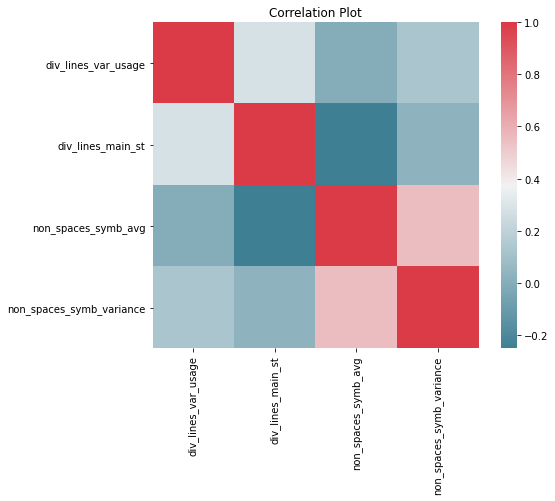

In [243]:
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [385]:
cols = num + ['were_missed']
# train = new_df[cols]
# df_x_train = pd.DataFrame(columns=cols)
print('Total examples', new_df.shape[0])

were_missed0 = new_df[new_df['were_missed'] == 0]
were_missed1 = new_df[new_df['were_missed'] == 1]
df_x_train0 = were_missed0[cols].sample(frac=0.30)
df_x_train1 = were_missed1[cols].sample(frac=0.30)
perc = df_x_train0.shape[0] / were_missed0.shape[0]
perc1 = df_x_train1.shape[0] / were_missed1.shape[0]
print('perc for parts',perc, perc1, df_x_train0.shape[0], df_x_train1.shape[0])
df_train = df_x_train1.append(df_x_train0, sort=False)
df_train.head()

Total examples 162
perc for parts 0.3103448275862069 0.3007518796992481 9 40


,main_st_number,ncss,var_usage,lines,diff_lines_var_usage,diff_lines_main_st,div_lines_var_usage,div_lines_main_st,non_spaces_symb_avg,non_spaces_symb_variance,were_missed
sample_id,,,,,,,,,,,
56.0,10,16,6,16,10,6,2.666667,1.6,23.375000,373.234375,1
46.0,5,10,2,12,10,7,6.000000,2.4,36.100000,527.090000,1
159.0,5,10,1,9,8,4,9.000000,1.8,25.400000,340.840000,1
109.0,5,9,4,10,6,5,2.500000,2.0,24.909091,566.991736,1
74.0,4,7,3,6,3,2,2.000000,1.5,33.142857,778.693878,1


In [386]:
perc = df_train.shape[0] / new_df.shape[0]
print('perc for union df',perc, df_train.shape[0])

total_indices = set(new_df.index)
df_train_indices = set(df_train.index)
test_indices = total_indices.difference(df_train_indices)
test_df = new_df[new_df.index.isin(test_indices)]
test_df = test_df[cols]
perc = test_df.shape[0] / new_df.shape[0]
print('perc for test_df df', perc, test_df.shape[0])

perc for union df 0.30246913580246915 49
perc for test_df df 0.6975308641975309 113


In [387]:
y_train = df_train.pop("were_missed") 
x_train = df_train.copy()
y_test = test_df.pop("were_missed") 
x_test = test_df.copy()
y_train = y_train.astype('int') 
y_test = y_test.astype('int') 

In [389]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(train, new_df['were_missed'], test_size=0.3, random_state=42)
x_test

,main_st_number,ncss,var_usage,lines,diff_lines_var_usage,diff_lines_main_st,div_lines_var_usage,div_lines_main_st,non_spaces_symb_avg,non_spaces_symb_variance
sample_id,,,,,,,,,,
3.0,11,17,7,21,14,10,3.000000,1.909091,23.250000,287.787500
5.0,10,16,7,19,12,9,2.714286,1.900000,22.789474,298.692521
8.0,10,16,8,19,11,9,2.375000,1.900000,21.473684,252.986150
7.0,9,15,7,17,10,8,2.428571,1.888889,21.166667,265.250000
19.0,9,18,5,23,18,14,4.600000,2.555556,32.045455,457.588843
49.0,9,19,8,18,10,9,2.250000,2.000000,35.526316,748.565097
57.0,8,12,4,10,6,2,2.500000,1.250000,25.909091,433.719008
12.0,7,11,5,12,7,5,2.400000,1.714286,24.769231,304.639053
43.0,6,11,2,14,12,8,7.000000,2.333333,30.833333,612.138889


In [390]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [391]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train.values, y_train.values)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [392]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 500}

In [393]:
rfc1=RandomForestClassifier(**CV_rfc.best_params_)
rfc1.fit(x_train.values, y_train.values)

RandomForestClassifier(max_depth=4, n_estimators=500)

In [394]:
pred=rfc1.predict(x_test.values)
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.7699115044247787


In [402]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(rfc1, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.7699115044247787


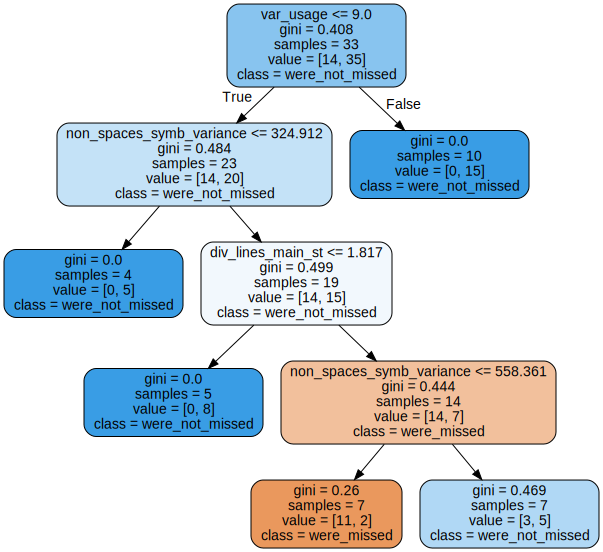

In [407]:
# import matplotlib.pyplot as plt
# from sklearn.tree import plot_tree

# fig = plt.figure(figsize=(15, 10))
# plot_tree(rfc1.estimators_[0], 
#           feature_names=x_train.columns,
#           class_names=['were_missed'], 
#           filled=True, impurity=True, 
#           rounded=True)
# !pip install graphviz

import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(rfc1.estimators_[0], 
                           feature_names=x_train.columns,
                           class_names=['were_missed', 'were_not_missed'], 
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='png')
graph

In [408]:
new_df.to_csv('new_df.csv')

In [477]:
for x, v in new_df.groupby('were_missed'):
    print(d.get(x), v.shape[0])

print('Filter by new_df.main_st_number == 2 and non_spaces_symb_variance < 201.265306122448')
new_df11 = new_df[~(new_df.index == 25)]
# new_df11 = new_df11[

for x, v in new_df11.groupby('were_missed'):
    print(d.get(x), v.shape[0])


were_missed 29
were_not_missed 133
Filter by new_df.main_st_number == 2 and non_spaces_symb_variance < 201.265306122448
were_missed 28
were_not_missed 133


In [482]:
for x, v in new_df11.groupby('were_missed'):
    print(d.get(x), v.shape[0])
    
print('Filter by new_df.main_st_number == 3 and lines > 10')
new_df12 = new_df11[~((new_df11.main_st_number == 3) & (new_df11.lines > 10))]
new_df12

# print('Filter by (main_st_number < 7) and (non_spaces_symb_avg < 6)')
# new_df11 = new_df[(new_df.main_st_number < 7.000000000001)]
# new_df11
for x, v in new_df12.groupby(['were_missed']):
    print(d.get(x), v.shape[0])

were_missed 28
were_not_missed 133
Filter by new_df.main_st_number == 2 and non_spaces_symb_variance < 201.265306122448
were_missed 27
were_not_missed 133


In [448]:
new_df[(new_df['main_st_number'] == 3) & (new_df['were_missed'] == 0)].describe()

,div_lines_var_usage,div_lines_main_st,non_spaces_symb_avg,non_spaces_symb_variance
count,5.000000,5.000000,5.000000,5.000000
mean,3.950000,2.666667,26.953074,378.745279
std,2.413504,0.849837,7.790802,156.139164
min,1.500000,2.000000,19.727273,238.222222
25%,2.250000,2.000000,20.800000,309.107438
50%,3.000000,2.333333,27.285714,316.560000
75%,6.000000,3.000000,27.666667,388.489796
max,7.000000,4.000000,39.285714,641.346939


In [449]:
new_df[(new_df['main_st_number'] == 3) & (new_df['were_missed'] == 1)].describe()

,div_lines_var_usage,div_lines_main_st,non_spaces_symb_avg,non_spaces_symb_variance
count,13.000000,13.000000,13.000000,13.000000
mean,3.711538,2.461538,26.100133,645.191055
std,2.340420,0.585922,6.098865,512.815436
min,1.000000,1.666667,16.285714,129.061224
25%,2.000000,2.000000,21.777778,334.617284
50%,2.500000,2.333333,27.444444,390.246914
75%,5.000000,2.666667,30.888889,805.836735
max,8.000000,3.333333,35.200000,1614.691358
